## 미션 1. 

In [1]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr
from itertools import combinations


from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind
from statsmodels.stats.anova import anova_lm 
from pingouin import anova, welch_anova
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from pandas import DataFrame, melt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

# 로지스틱 결과 판별 참조 + 머신러닝 라이브러리
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
origin = load_data('insurance')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.

데이터셋 크기: (1338, 7)
열 개수: 7
행 개수: 1338
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   objec

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [4]:
display(origin.describe().T)
print(origin.isna().sum())
display(origin[['sex','smoker','region']].nunique())
display(origin[['sex']].value_counts(normalize = True) * 100)
display(origin[['smoker']].value_counts(normalize = True) * 100)
display(origin[['region']].value_counts(normalize = True) * 100)

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


sex       2
smoker    2
region    4
dtype: int64

sex   
male      50.523169
female    49.476831
Name: proportion, dtype: float64

smoker
no        79.521674
yes       20.478326
Name: proportion, dtype: float64

region   
southeast    27.204783
northwest    24.289985
southwest    24.289985
northeast    24.215247
Name: proportion, dtype: float64

### 인사이트

- 해당 데이터 셋에서 결측치는 발견되지 않았다. 하지만 'charges'에서 평균값이 중앙값보다 높게 나온것으로 보아, 이상치가 존재한다는 것으로 판단된다.
  'charges' 에 한정하여, 후에 로그 변환을 통해 정규성과 등분산성을 보다 잘 만족시키도록 개선한다.

- 기초통계량을 통해 확인한 결과, 'charges'변수에서 음수 값은 존재하지 않으나, 고액 의료비에 해당하는 관측치로 인해 극단값이 확인된다.

- 범주형 변수(sex, smoker, region)은 각각 2개, 2개, 4개의 범주로 구성되어 있고, 'smoker'변수의 경우 수치적으로는 데이터가 몰림이 있다.

- 기초통계량 및 분포 확인 결과, 데이터 품질이 전반적으로 양호하여 결측치 제거 또는 이상치 삭제와 같은 강한 전처리는 필요하지 않았다.

- 'charges'의 평균 값은 13270 USD로 한국 돈으로 환산하면 대략 1900만원이다. 의료비가 매우 비싼 미국이라는 점을 감안하면, 비현실적이라고 볼 수는 없다.

  보험 플랜, 보장 범위 등 여러 요인을 고려하면 현실적인 의료비 수준인지 본 데이터 셋만으로는 설명하기 어렵다.

## 미션 2 "의료비와 핵심 변수의 첫인상"

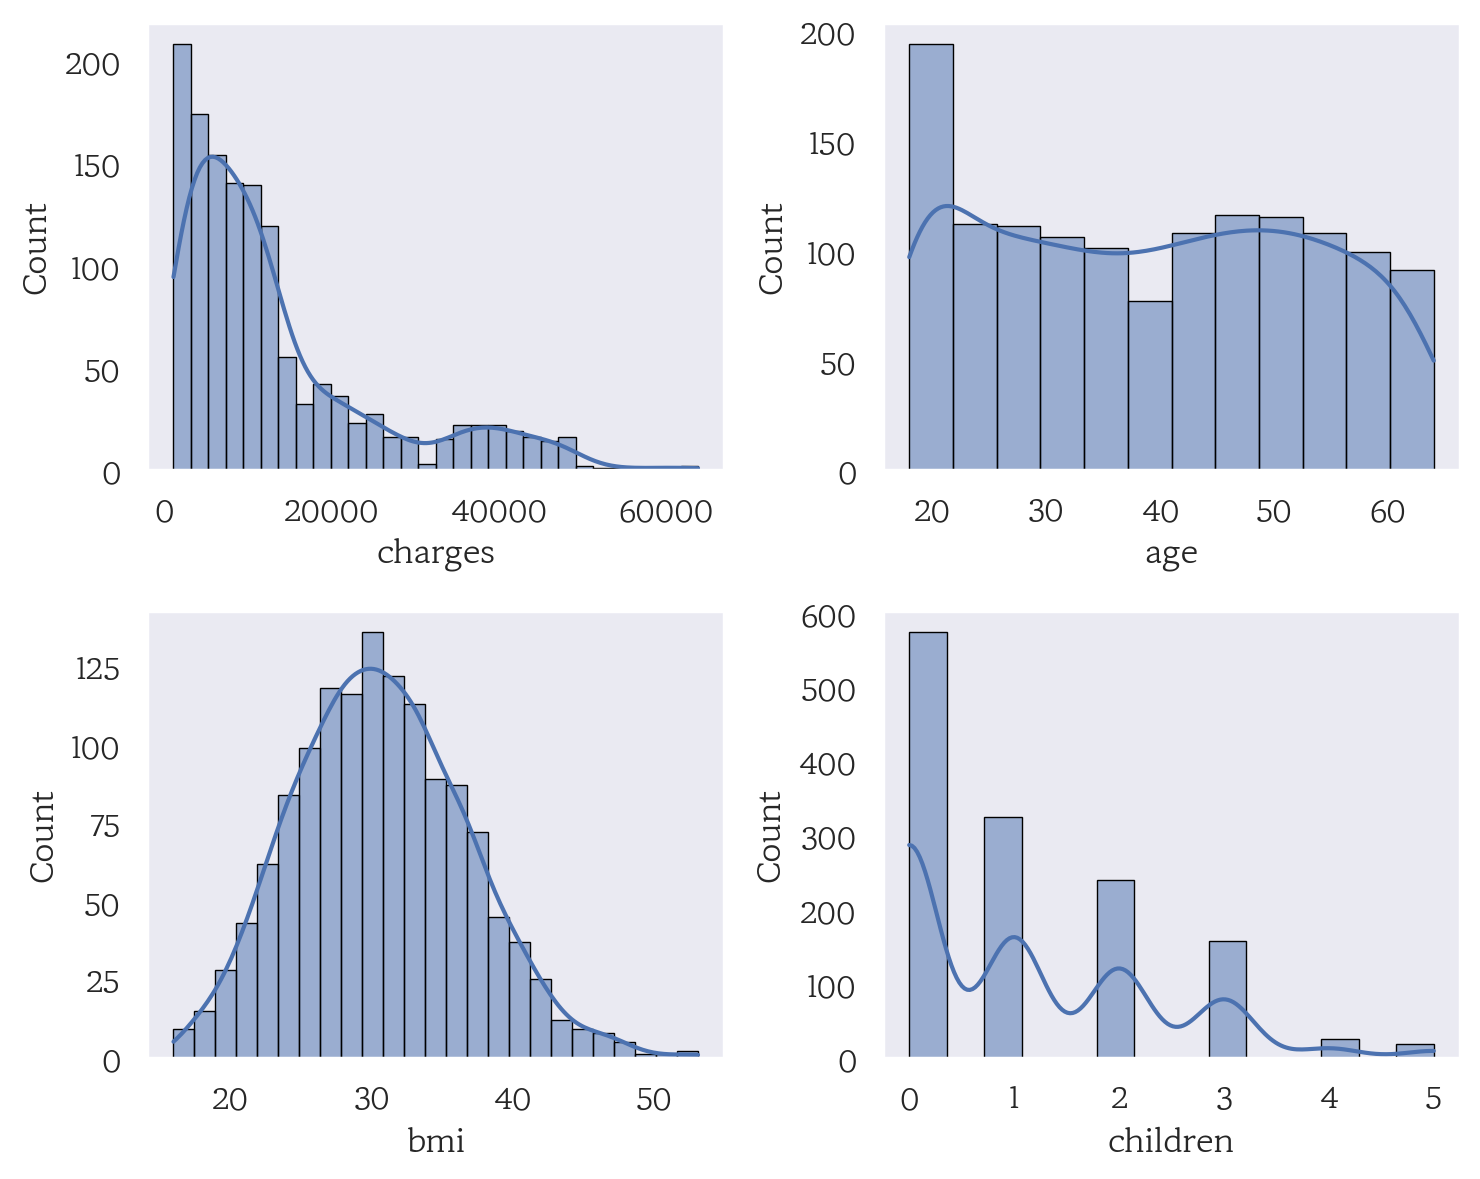

In [5]:
width_px = 1500
height_px = 1200
rows = 2
cols = 2
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

sb.histplot(data = origin, x = 'charges', kde = True, ax = ax[0][0],
            edgecolor ='#000000', linewidth = 0.5)
sb.histplot(data = origin, x = 'age', kde = True, ax = ax[0][1],
            edgecolor ='#000000', linewidth = 0.5)
sb.histplot(data = origin, x = 'bmi', kde = True, ax = ax[1][0],
            edgecolor ='#000000', linewidth = 0.5)
sb.histplot(data = origin, x = 'children', kde = True, ax = ax[1][1],
            edgecolor ='#000000', linewidth = 0.5)


# 출력
plt.tight_layout()
plt.show()
plt.close()


### 인사이트

- charges를 제외한 나머지 변수들은 분포 범위가 제한적이며 극단적으로 긴 꼬리를 보이지 않는다.

  age와 bmi는 비교적 안정적인 범위 내에서 분포하며,

  charges는 다른 변수들과 비교했을 때 분포의 비대칭성이 가장 크다.

- 이상치가 존재하는 경우, 변수에 대한 설명력이 저하되며 

  왜도가 심한 경우, 잔차의 분산이 고르지 않아 등분산성 가정 위배가 발생하며 회귀계수에 대한 신뢰성이 떨어진다.

  로그변환은 비대칭성을 완화하고, 분산을 안정화하며, 등분산성 가정 충족 여부를 보다 원활하게 만들어 준다.

- charges는 평균이 중앙값보다 크게 나타나며, 분포의 오른쪽 꼬리가 길게 늘어진 우측 왜도 분포를 보인다.

  age는 평균과 중앙값이 비교적 유사하며, 꼬리가 짧아 분포의 비대칭성이 크지 않다.

  bmi는 평균과 중앙값이 거의 일치하고, 좌우 꼬리가 비교적 대칭적인 형태를 보인다.

  children은 이산형 변수로 평균과 중앙값의 해석이 제한적이며, 값이 증가할수록 빈도가 감소하는 우측 꼬리 분포를 보인다.

- 의료비의 long-tail분포는 소수의 극단적 고액청구가 전체 결과에 영향을 미칠수 있다.

## 미션 3 "로그/비선형 변환을 고민해 보자"

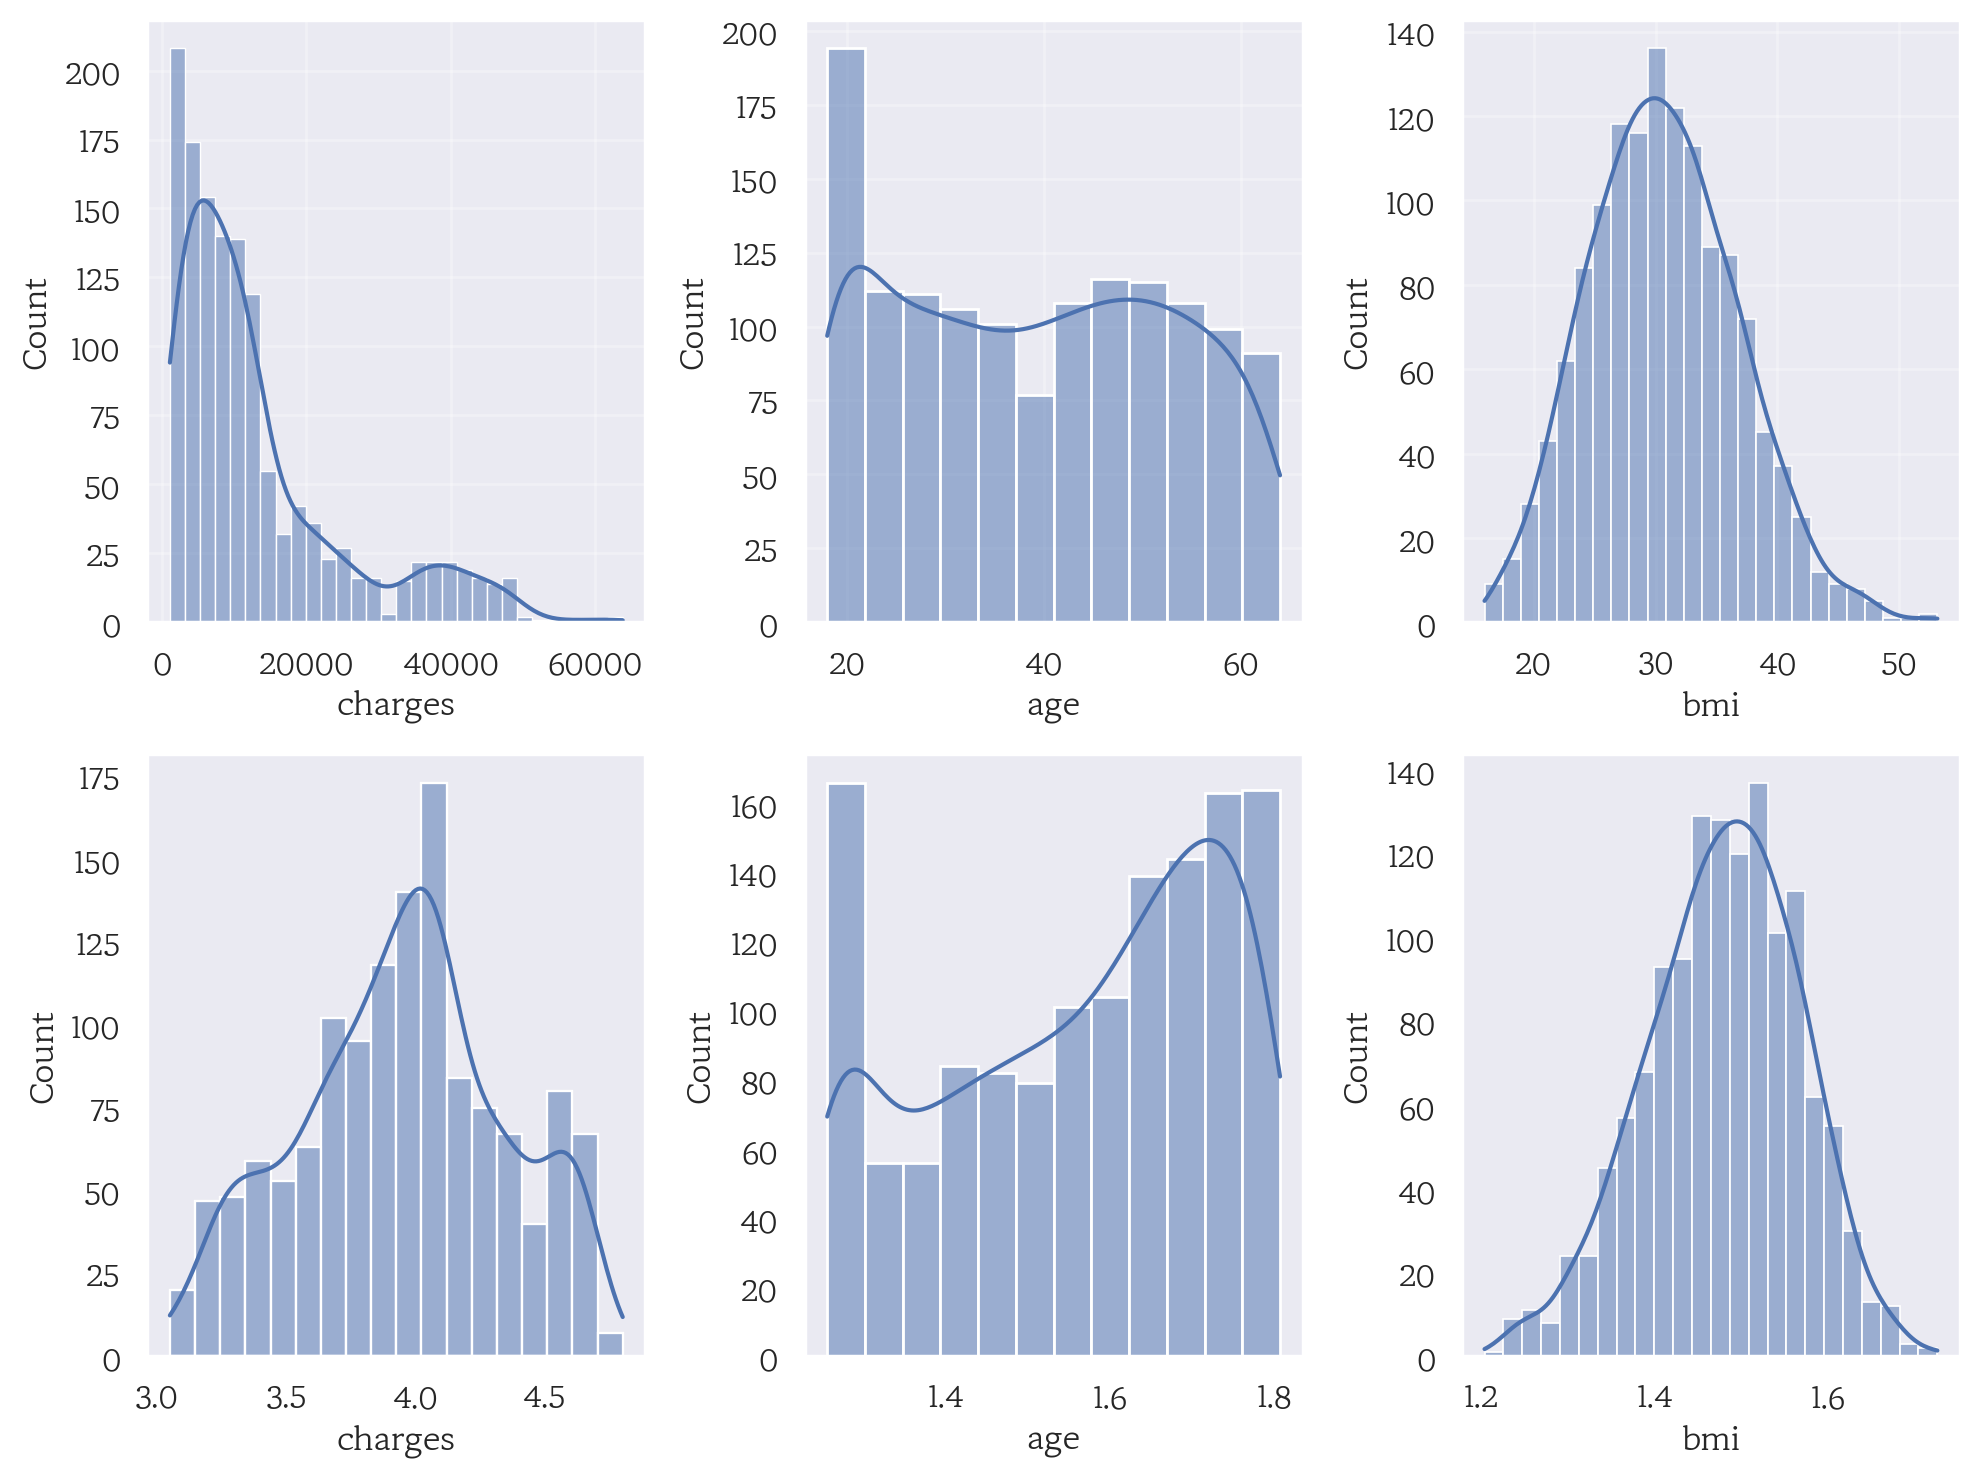

In [6]:
width_px = 2000
height_px = 1500
rows = 2
cols = 3
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i, col in enumerate(['charges','age','bmi']):
    data = origin[origin[col] > 0][col]
    log_data = np.log10(data)

    sb.histplot(data, kde = True, ax=ax[0][i])
    ax[0][i].grid(True, alpha = 0.3)

    sb.histplot(log_data, kde = True, ax=ax[1][i])
    ax[0][i].grid(True, alpha = 0.3)
# 출력
plt.tight_layout()
plt.show()
plt.close()

### 인사이트

- 장점:로그변환은 잔차의 정규성과 등분산성 충족 가능성을 높인다.

       회귀계수 추정의 안정성이 향상된다.

       선형성에 가깝게 변환이 가능하다.

- 단점: 모든 변수에 로그변환을 취할 경우, 'children' 변수처럼 오히려 더 복잡해질 수 있다. 직관성이 저하된다.`

- 어떻게 달라질까? -> 상대적(비율) 해석으로 변화한다. 결론 내용을 전달할때, 로그계산값(비율값)과 직관적인 금액에 대한 값을 함께 전달해주어야 함.

- 이 변환이 없으면 어떤 함정에 빠질까? -> 소수의 long-tail 분포(극단적 고액 청구)에 의해 통계적 추론이 왜곡될 수 있다. 

## charges 로그 변환

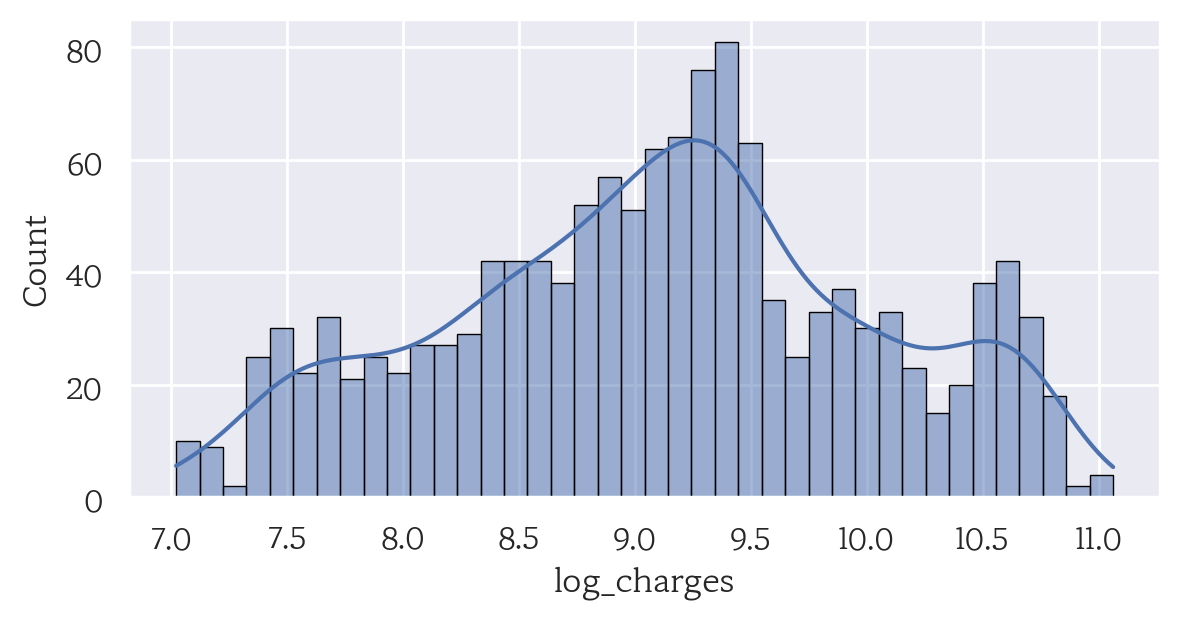

In [7]:
df_log = origin.copy()
df_log['log_charges'] = np.log1p(df_log['charges'])

width_px = 1200
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# histogram 그리기
sb.histplot(data = df_log, x = 'log_charges', ax=ax, kde = True, bins = 40,
            edgecolor ='#000000', linewidth = 0.5)
# 그래프 꾸미기
ax.grid(True) # 배경 격자 표시/숨김

# 출력
plt.tight_layout()
plt.savefig('myplot.png', dpi = my_dpi)
plt.show()
plt.close()

## 미션 4 "성별과 거주 지역은 의료비를 결정할까?"

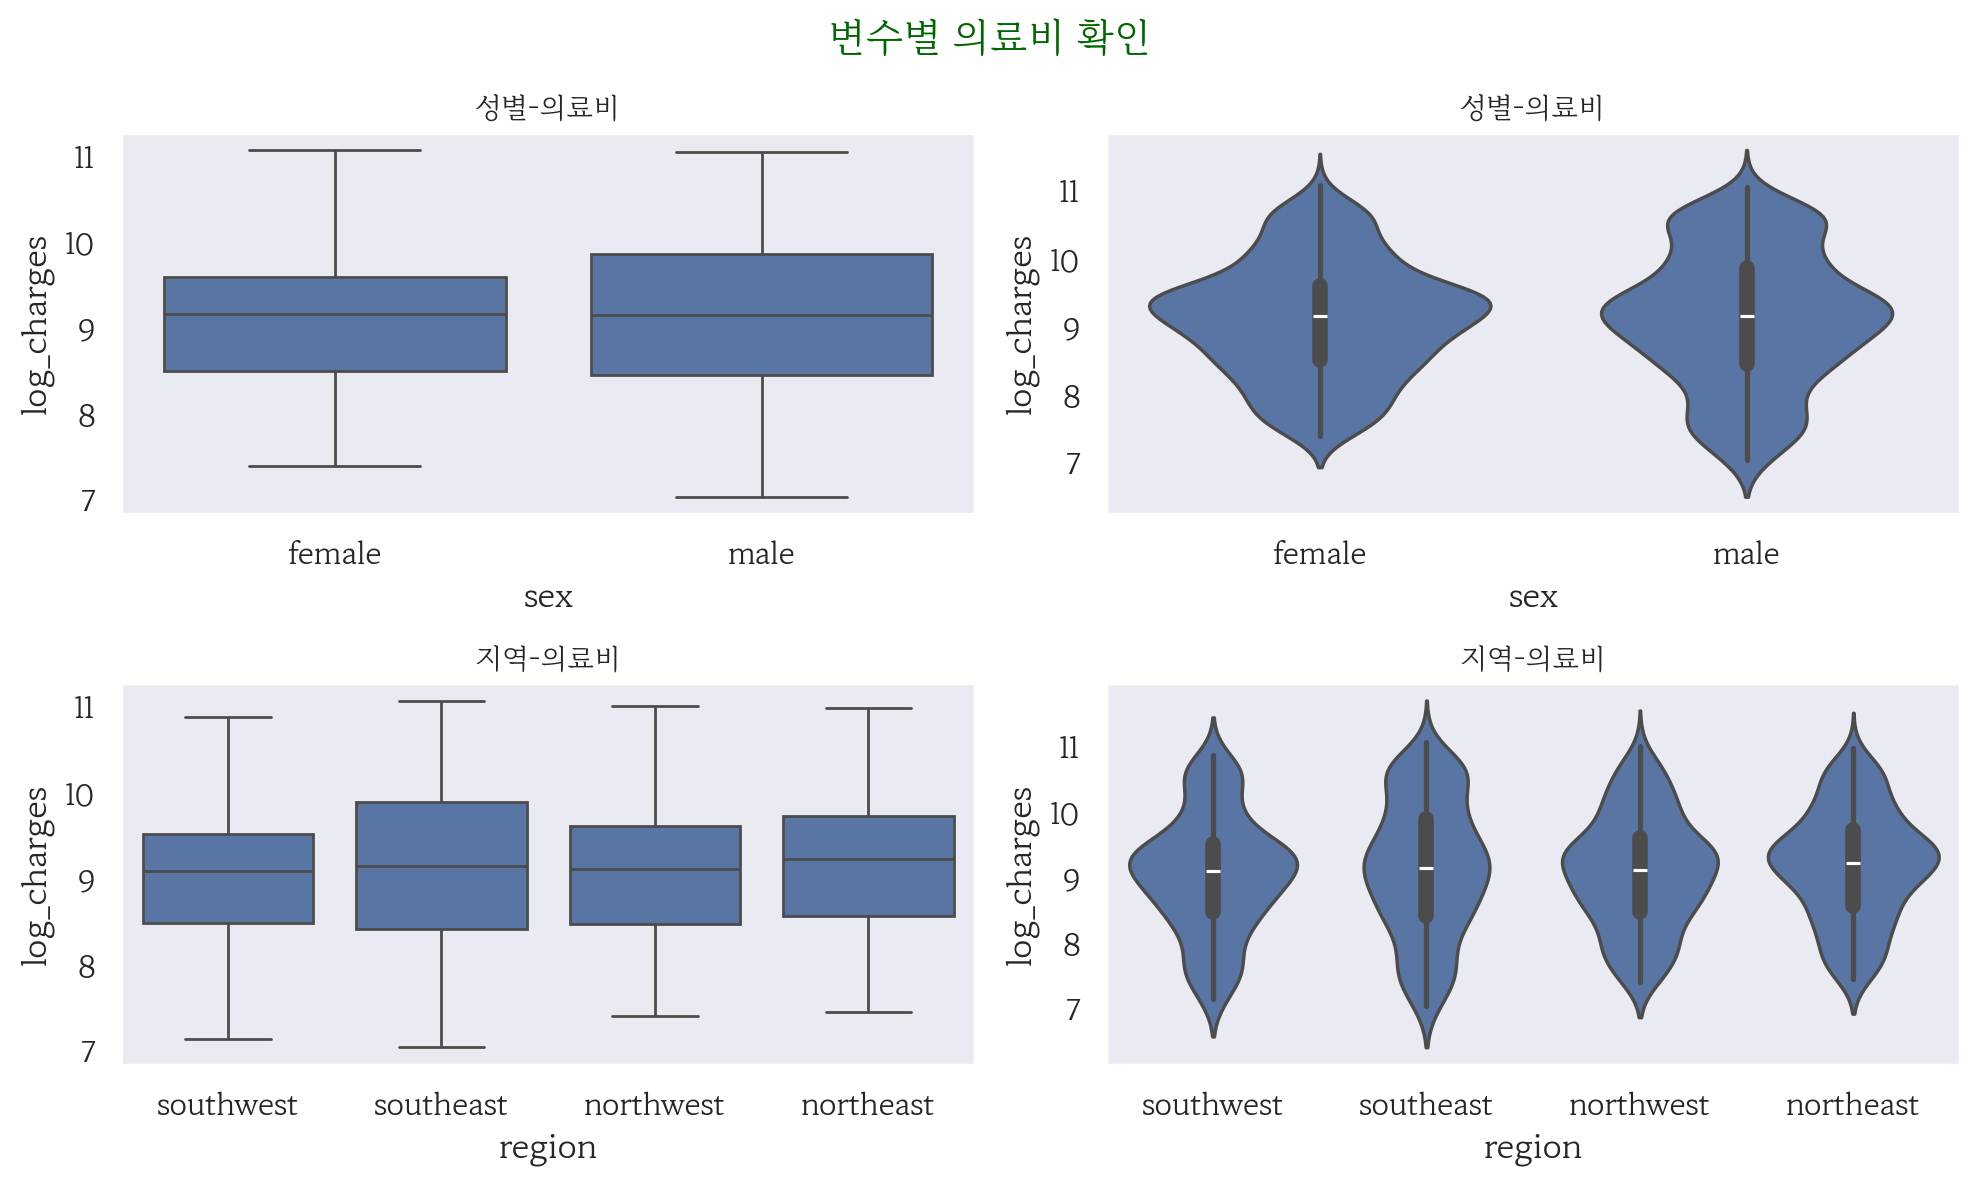

In [8]:
width_px = 2000
height_px = 1200
rows = 2                                                     
cols = 2                                                             
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

sb.boxplot(data=df_log, x = 'sex', y = 'log_charges', ax=ax[0][0])
sb.violinplot(data=df_log, x = 'sex', y = 'log_charges', ax=ax[0][1])
sb.boxplot(data=df_log, x = 'region', y = 'log_charges', ax=ax[1][0])
sb.violinplot(data=df_log, x = 'region', y = 'log_charges', ax=ax[1][1])

fig.suptitle('변수별 의료비 확인', fontsize = 14, color ='#006600')

fig.subplots_adjust(wspace = 0.2, hspace = 0.2)

ax[0][0].set_title('성별-의료비', fontsize =10)
ax[0][1].set_title('성별-의료비', fontsize =10)
ax[1][0].set_title('지역-의료비', fontsize =10)
ax[1][1].set_title('지역-의료비', fontsize =10)


plt.tight_layout()
plt.show()
plt.close()


### 인사이트

- 어느 집단이 비싼가?(성별) 

  남성 집단에서 중앙값과 상위 사분위 범위가 여성보다 다소 높게 나타나며 고액 의료비 관측치도 더 많이 관찰된다. 

- 차이가 얼마나 뚜렷한가?

  두 집단의 분포가 크게 중첩되어 있어 성별 단독 변수만으로 의료비 차이가 뚜렷하다고 단정하기는 어렵다.

 
- 어느 집단이 비싼가?(지역)

  southeast와 northeast 지역의 중앙값이 다른 지역보다 약간 높게 위치한다.

- 차이가 얼마나 뚜렷한가?

  네 지역 모두 중앙값 위치가 유사하고 분포가 크게 겹친다.

  고액 의료비 구간에서도 지역 간 분포가 상당 부분 중첩되어, 지역 간 차이는 제한적이며 명확한 우열을 단정하기 어렵다.

- 왜 유의미한 차이가 발생하지 않을까?

  각 변수('sex', 'region')별로 약간의 차이가 있긴 하지만, 유의미한 차이는 보이지 않는다. 

  의료비 분포 차이는 미국 보험 회사 간의 경쟁, 의료 이용 패턴 등 복합적인 요소가 반영될 가능성이 있기 때문에, 

  본 데이터셋으로는 설명력이 떨어진다.

- 미국은 다보험자 체계로 보험사 및 플랜에 따라 의료비 청구 구조가 상이하다. 즉 똑같은 조건의 두 사람을 비교했을때도 보험사에 따라 수가책정 방식의 차이로 인해
  
  본 데이터셋에는 이러한 제도적 변수들이 포함되어 있지 않으므로,

  관찰된 성별·지역별 의료비 차이는 구조적 원인이라기보다 개인 특성과 표본 구성의 영향을 반영한 결과로 해석하는 것이 타당하다. 

## 미션 5. "흡연은 정말로 의료비를 크게 높일까?"

In [9]:
df_log2 = df_log.copy()
df_log['smoker'] = origin['smoker'].map({'yes':'1', 'no':'0'})
df_log

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,1,southwest,16884.92400,9.734236
1,18,male,33.770,1,0,southeast,1725.55230,7.453882
2,28,male,33.000,3,0,southeast,4449.46200,8.400763
3,33,male,22.705,0,0,northwest,21984.47061,9.998137
4,32,male,28.880,0,0,northwest,3866.85520,8.260455
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,0,northwest,10600.54830,9.268755
1334,18,female,31.920,0,0,northeast,2205.98080,7.699381
1335,18,female,36.850,0,0,southeast,1629.83350,7.396847
1336,21,female,25.800,0,0,southwest,2007.94500,7.605365


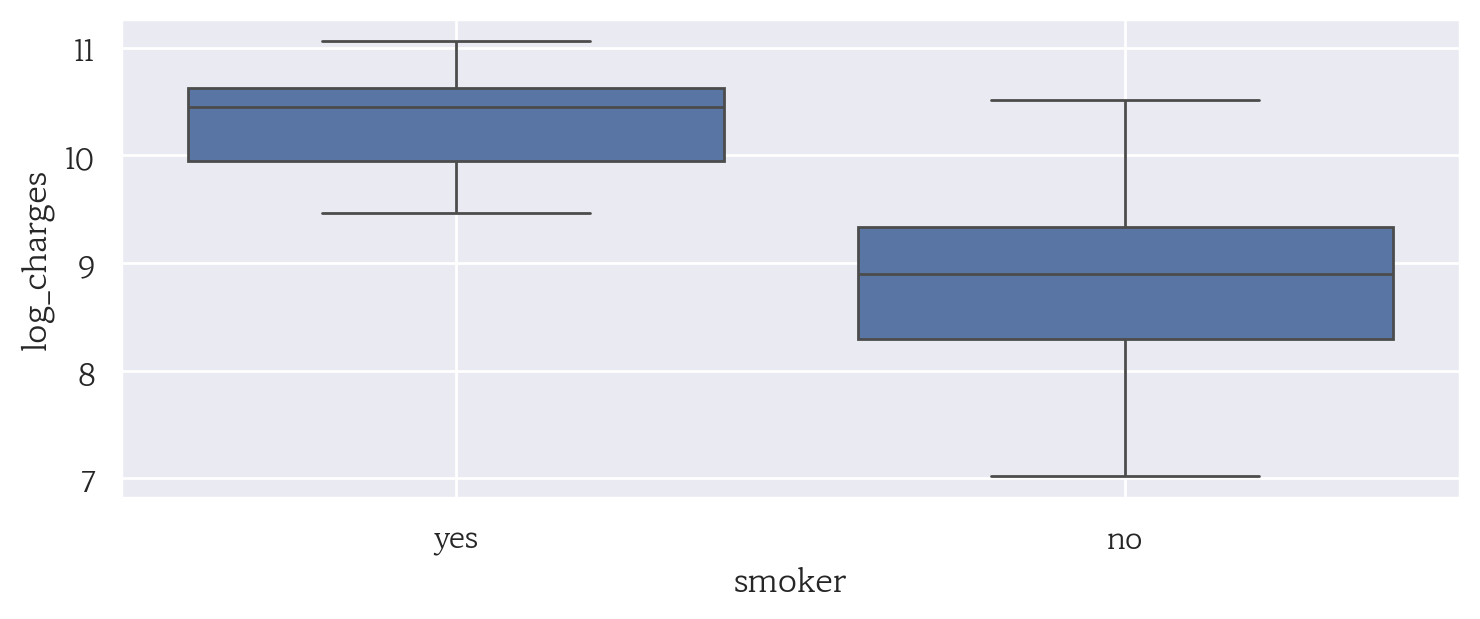

In [10]:
width_px = 1500
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)


sb.boxplot(data=df_log2,
             x ='smoker',
             y ='log_charges'                         
          )       

ax.grid(True)

# 출력
plt.tight_layout()
plt.show()
plt.close()

In [11]:
# smoker yes / no 데이터 추출 (Series)
log_sy = df_log2.loc[df_log2['smoker'] == 'yes', 'log_charges'].reset_index(drop=True)
log_sn = df_log2.loc[df_log2['smoker'] == 'no',  'log_charges'].reset_index(drop=True)

# t-test용 DataFrame 생성 (yes / no 나란히)
ttest_df = pd.DataFrame({
    'smoker_yes': log_sy,
    'smoker_no':  log_sn
})

ttest_df.tail()

# 흡연자 - 비흡연자 데이터 수가 달라서 Null값 존재 -> 후에 ttest 진행하면서 dropna 필수

,smoker_yes,smoker_no
1059,NaN,9.342481
1060,NaN,9.268755
1061,NaN,7.699381
1062,NaN,7.396847
1063,NaN,7.605365


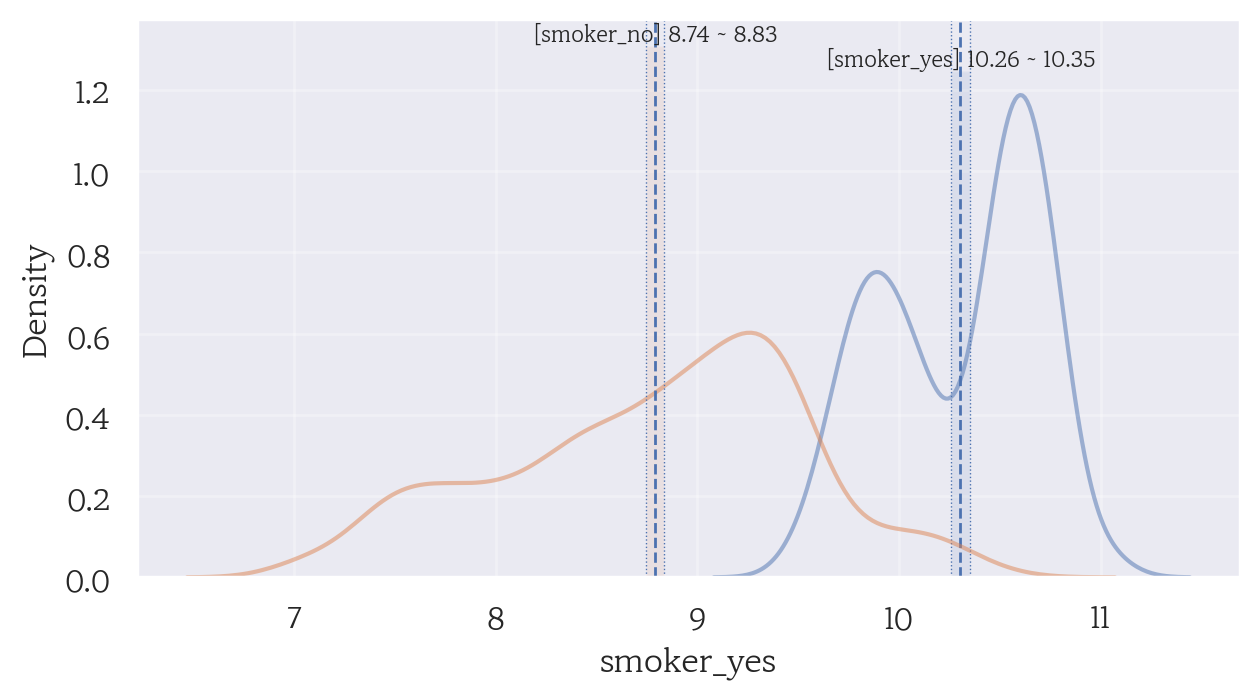

In [12]:
from math import sqrt

data = ttest_df[['smoker_yes', 'smoker_no']]  # 확인할 데이터

# 1) 그래프 초기화
width_px = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    # KDE Plot
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5, ax=ax)

    # 신뢰구간 계산
    clevel = 0.95
    dof = len(data[c].dropna()) - 1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c].dropna()))

    cmin, cmax = t.interval(
        clevel,
        dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    # 신뢰구간 표시
    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트
    ax.text(
        x=(cmax - cmin) / 2 + cmin,
        y=ymax,
        s="[%s] %.2f ~ %.2f" % (c, cmin, cmax),
        ha="center",
        va="bottom",
        fontsize=8
    )

# 그래프 꾸미기
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

개별 관측치 수준에서도 흡연 여부에 따른 의료비 분포 차이가 뚜렷하다. 이는 단순 평균 차이를 넘어 분포 수준의 차이를 시사한다.

In [13]:
data = ttest_df[['smoker_yes', 'smoker_no']] # 검사하려는 데이터 추출
equal_var_fields = []
normal_dist = True
report = []
for c in data.columns:
    series = data[c].dropna()
    s, p = normaltest(series)
    
    normalize = p > 0.05
    report.append({
         "field": c,
         "statistic": s,
         "p-value": p,
         "result": normalize
    })
    normal_dist = normal_dist and normalize

# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    values = [data[c].dropna() for c in data.columns]                 # Nan값을 제외시킨 데이터 준비

    if normal_dist:
        n = "Bartlett"
# 정규성을 충족할 경우의 검정방법
        s, p = bartlett(*values) # 모든 컬럼의 데이터를 한번에 전달

    else:
        n = "Levene" # 정규성을 충족하지 않을 경우의 검정방법
        s, p = levene(*values, center='median') # 모든 컬럼의 데이터를 한번에 전달
   
    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
   })
report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
smoker_yes,182.441412,2.417412e-40,False
smoker_no,37.435884,7.428501e-09,False
Levene,89.473006,1.347330e-20,False


- 본 데이터는 집단별 정규성 가정을 충족하지 않으며, 분산 또한 동일하다고 보기 어려워 등분산·정규성 가정을 전제로 한 검정은 부적절하다.
- welch t-test 진행

In [14]:
t_stat, p_value = ttest_ind(
    ttest_df['smoker_yes'].dropna(),
    ttest_df['smoker_no'].dropna(),
    equal_var=False
)

t_stat, p_value

print(
    "Welch t-test: statistic = {:.3f}, p_value = {:.3f}, decision = {}"
    .format(t_stat, p_value,'대립' if p_value < 0.05 else '귀무')
)

Welch t-test: statistic = 46.371, p_value = 0.000, decision = 대립


### 인사이트

- Welch의 t-검정 결과, 흡연자와 비흡연자 간 의료비 차이는 통계적으로 매우 유의하였으며(t = 46.37, p < 0.001), 이는 흡연 여부가 의료비 수준에 있어 

  실질적으로 큰 효과 크기를 갖는 요인임을 시사한다.

- 해당 분석결과는 단순히 흡연자의 의료 비용 지출이 비흡연자보다 많다는 것을 시사하는 것 뿐만 아니라, 두 집단에 대한 의료비 분포가 명확하다는 점이다.

- 뒷받침 내용

  (한국 건강보험(공보험)에서는 실제로 금연치료 지원사업을 진행중에 있다. 연 2회에 걸쳐서 건강보험이 적용이 된다)

  미국의 경우 ACA(오바마케어)가 존재하며 tobacco surcharge의 제도에서 흡연자 보험료를 최대 50%까지 할증을 한다는 내용을 살펴볼 수 있다.

  트럼프 정권에 들어오면서 ACA 법 중 일부는 제제가 가해졌지만(의무가입), tobacco surcharge의 경우는 연방법이기 때문에 유지되고 있다.

  본 분석에서 확인된 흡연자의 높은 의료비 지출은 흡연 관련 질환의 영향이 주요 원인으로 해석될 수 있다. 다만, 미국의 다보험자 시스템과 흡연자에 대한 보험료 

  할증(tobacco surcharge) - 출처(Affordable Care Act)과 같은 제도적 장치는 흡연자를 고위험 집단으로 분류하고 관리하는 정책적 맥락을 형성하며, 이러한 의료비 격차가 제도적으로도 인식되고 있음을 시사한다.

  미국 - 보험가입은 의무가 아닌 선택, 공보험(Medicare, Mediaid)은 가입할 수 없는(또는 가입을 하지 않은) 특정 취약계층의 최소한의 보장권을 주기 위한 것.

         다보험자 시스템은 이러한 미국적 특징(자유)를 잘 보여주는 시스템이기도 하며, 공보험을 유지함으로써 최소한의 취약계층에 대한 보호는 한다.

## 미션 6. "나이대별로 의료비 차이가 뚜렷할까?"

In [15]:
bins = [18, 30, 40, 50, 65]
labels = ['18-29', '30-39', '40-49', '50-64']

df_log2['age_group'] = pd.cut(
    df_log2['age'],
    bins=bins,
    labels=labels,
    right=False
)
df_log2['age_group'].value_counts().sort_index


<bound method Series.sort_index of age_group
18-29    417
50-64    385
40-49    279
30-39    257
Name: count, dtype: int64>

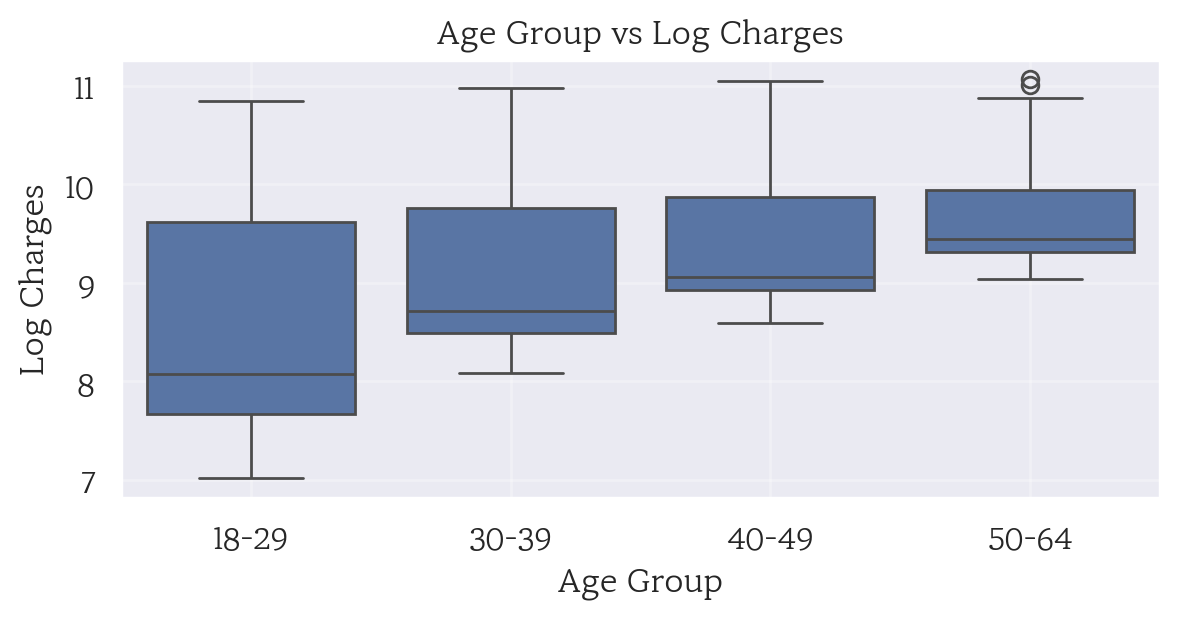

In [16]:
width_px = 1200
height_px = 640
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.boxplot(
    data=df_log2,
    x='age_group',
    y='log_charges',
    ax=ax
)

ax.set_title('Age Group vs Log Charges')
ax.set_xlabel('Age Group')
ax.set_ylabel('Log Charges')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

- 통계에서 가장 흔한 나이 구분법을 적용하여 시각화를 하였다 (18~29: 청년기, 30~39: 초기 중년, 40~39: 중년, 50~64: 중장년(의료비 급증구간))

연령대(age_group)를 기준으로 한 Welch 분산분석 결과, 연령대에 따라 의료비(log_charges)의 평균에는 통계적으로 유의한 차이가 존재한다a(p < 0.05).

In [17]:
import pingouin as pg
anova = pg.welch_anova(
    data=df_log2,
    dv='log_charges',
    between='age_group'
)

display(anova)

p_anova = anova.loc[0, 'p-unc']

if p_anova < 0.05:
    print("\n▶ Welch 분산분석 결과, 연령대에 따른 의료비 평균에는 통계적으로 유의한 차이가 존재한다 (p < 0.05).")
else:
    print("\n▶ Welch 분산분석 결과, 연령대별 의료비 평균 차이는 통계적으로 유의하지 않다 (p ≥ 0.05).")

,Source,ddof1,ddof2,F,p-unc,np2
0,age_group,3,669.295926,151.16214,8.540616e-75,0.261208



▶ Welch 분산분석 결과, 연령대에 따른 의료비 평균에는 통계적으로 유의한 차이가 존재한다 (p < 0.05).


In [18]:
import pingouin as pg
posthoc = pg.pairwise_gameshowell(
    data=df_log2,
    dv='log_charges',
    between='age_group'
)

display(posthoc)

df_posthoc = posthoc[posthoc['pval'] < 0.05]

if len(df_posthoc) > 0:
    print("\n▶ 사후검정 결과, 일부 연령대 조합에서 의료비 차이가 통계적으로 유의하게 나타났다.")
else:
    print("\n▶ 사후검정 결과, 연령대 간 유의한 의료비 차이는 확인되지 않았다.")


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,18-29,30-39,8.475574,9.023750,-0.548176,0.070938,-7.727581,661.049682,4.393153e-13,-0.564338
1,18-29,40-49,8.475574,9.346482,-0.870909,0.064588,-13.484145,679.358919,1.757483e-13,-0.941808
2,18-29,50-64,8.475574,9.644533,-1.168960,0.058733,-19.902985,596.428510,5.995204e-14,-1.369501
3,30-39,40-49,9.023750,9.346482,-0.322733,0.060021,-5.377036,495.094832,6.986879e-07,-0.468074
4,30-39,50-64,9.023750,9.644533,-0.620784,0.053670,-11.566699,403.776651,1.068035e-13,-1.006785
5,40-49,50-64,9.346482,9.644533,-0.298051,0.044943,-6.631751,519.244732,5.002418e-10,-0.538592



▶ 사후검정 결과, 일부 연령대 조합에서 의료비 차이가 통계적으로 유의하게 나타났다.


In [19]:
age_rank = (
    df_log2
    .groupby('age_group')['log_charges']
    .mean()
    .reset_index()
    .sort_values('log_charges', ascending=False)
)

age_rank['rank'] = range(1, len(age_rank) + 1)

display(age_rank)

print("\n▶ 의료비 연령 서열은 평균 의료비(log_charges)를 기준으로 정리되었다.")
print("▶ 상위 연령대일수록 의료비 수준이 높은 경향을 보인다.")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20872\2850146164.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('age_group')['log_charges']


,age_group,log_charges,rank
3,50-64,9.644533,1
2,40-49,9.346482,2
1,30-39,9.023750,3
0,18-29,8.475574,4



▶ 의료비 연령 서열은 평균 의료비(log_charges)를 기준으로 정리되었다.
▶ 상위 연령대일수록 의료비 수준이 높은 경향을 보인다.


## 미션 7. "변수들은 서로 섞여 있을까?"

In [20]:
df2 = df_log2.filter(['age','bmi','children','log_charges'])
df2.head()

,age,bmi,children,log_charges
0,19,27.900,0,9.734236
1,18,33.770,1,7.453882
2,28,33.000,3,8.400763
3,33,22.705,0,9.998137
4,32,28.880,0,8.260455


ValueError: Invalid RGBA argument: 0.2

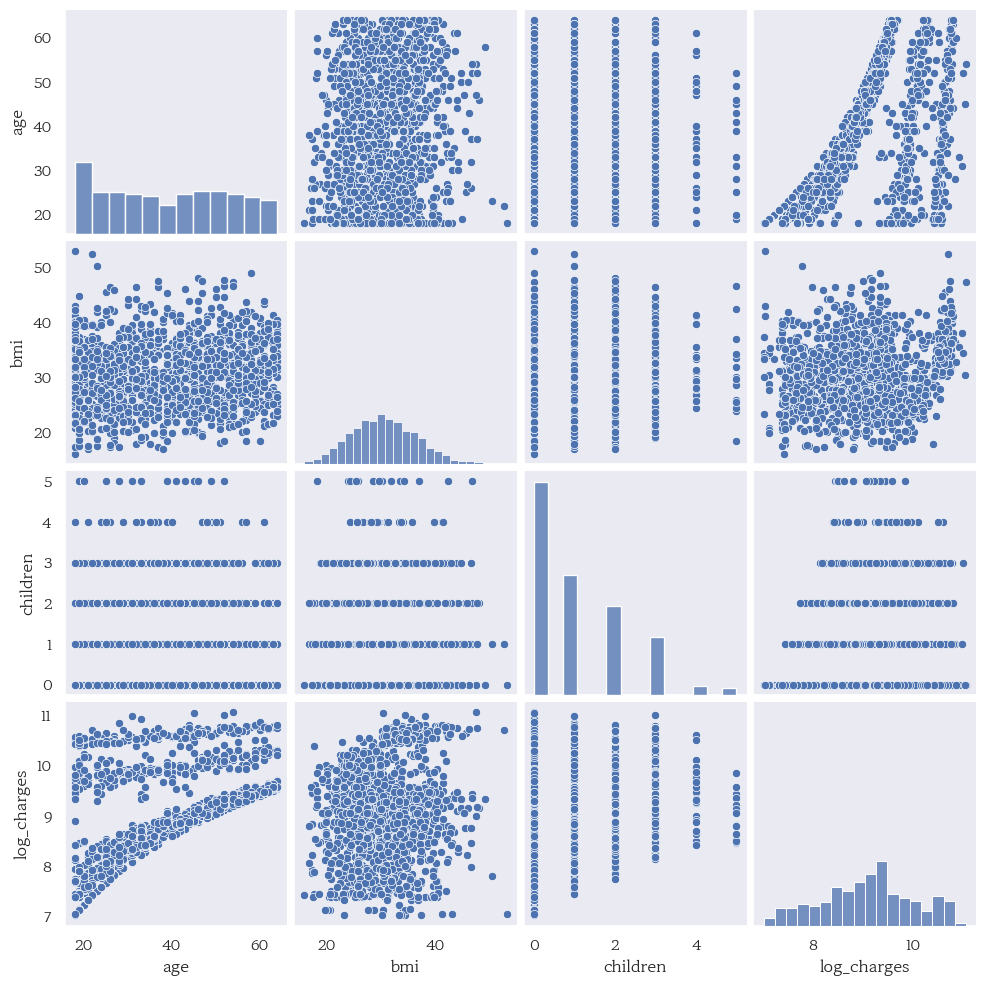

In [21]:
width_px = 1600
height_px = 1200
figsize = (width_px/ my_dpi, height_px / my_dpi)

# pairplot 그리기
# 'corner=True' 파라미터 추가 시 아래쪽 삼각형만 플롯된다
# 'diag_kind' 파라미터에 'hist'값 적용, 'kde': 기본값, 범주별 구분 시 사용
# x_vars, y_vars 파라미터에 원하는 변수를 선택적으로 적용한다, 선택적 변수 적용 시 사용
g= sb.pairplot(df2,diag_kind ='hist')

# 그룹별로 묶어서 표시할 때 사용
g.map_lower(sb.kdeplot, levels = 1, color = 0.2)
g.fig.set_figwidth(figsize[0])                                                                          
g.fig.set_dpi(my_dpi)
g.fig.set_figheight(figsize[1])

# 출력
plt.grid()
plt.show()
plt.close()

In [22]:
skew_outlier = {}
for col in df2.columns:
    temp = df2[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count
    }

skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z|>3)
age,0.055673,-0.988574,0.0
bmi,0.284047,-0.963062,4.0
children,0.938380,0.432129,18.0
log_charges,-0.089817,-0.595790,0.0


In [23]:
rows = []

for a, b in combinations(df2.columns, 2):
    x = df2[a]
    y = df2[b]

    # 선형성 확인(Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power = 2, use_f = True)
    linearity_ok = reset.pvalue > 0.05

    # 이상치 존재 여부(|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z|>3)'] > 0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z|>3)'] > 0
    outlier_flag = a_flag or b_flag
    
    # 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = "pearson"
        corr, pval = pearsonr(x, y)
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x, y)

    # 유의성 판단 (p <= 0.05)
    significant = pval <= 0.05

    # 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = 'Very strong'
    elif abs_r >= 0.60:
        strength = 'Strong'
    elif abs_r >= 0.40:
        strength = 'Medium'
    elif abs_r >= 0.20:
        strength = 'Weak'
    else:
        strength = 'Very weak'
    
    # 행 추가
    rows.append({
        'var_a': a,
        'var_b': b,
        'linearity': linearity_ok,
        'outlier_flag': outlier_flag,
        'chosen': chosen,
        'corr': corr,
        'pval': pval,
        'significant': significant,
        'strength': strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,age,bmi,True,True,spearman,0.107736,7.859093e-05,True,Very weak
1,age,children,False,True,spearman,0.056992,3.711959e-02,True,Very weak
2,age,log_charges,False,False,spearman,0.534392,1.130692e-99,True,Medium
3,bmi,children,True,True,spearman,0.015607,5.684234e-01,False,Very weak
4,bmi,log_charges,True,True,spearman,0.119396,1.192606e-05,True,Very weak
5,children,log_charges,False,True,spearman,0.133339,9.846806e-07,True,Very weak


In [24]:
# 등장하는 모든 변수 목록 추출
vars =sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index = vars, columns = vars)

# summary_df 내용 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a,b] = r
    corr_matrix.loc[b,a] = r # 대칭

# 대각선을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

corr_matrix

,age,bmi,children,log_charges
age,1.000000,0.107736,0.056992,0.534392
bmi,0.107736,1.000000,0.015607,0.119396
children,0.056992,0.015607,1.000000,0.133339
log_charges,0.534392,0.119396,0.133339,1.000000


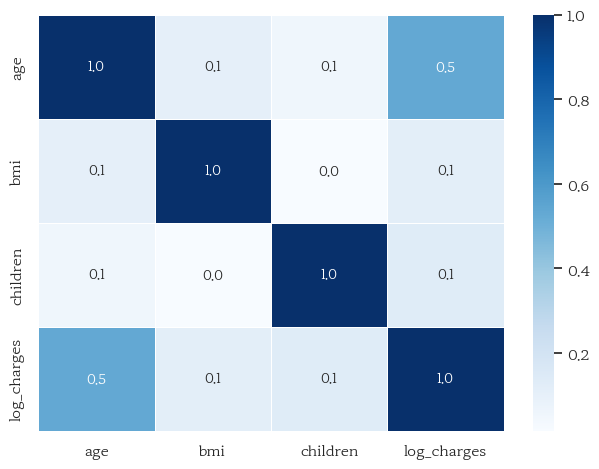

In [25]:
width_px = 1200
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)

# lmplot 그리기
sb.heatmap(data=corr_matrix, annot = True, fmt = '0.1f', linewidth = 0.5,
           cmap = 'Blues', annot_kws = {'size': 10}) # col, row 선택사항

# 출력
plt.tight_layout()
plt.show()
plt.close()

- age와 bmi는 낮은 상관관계를 보이며, 독립적이다.

  나이와 비만율은 서로 상관관계가 없다

In [26]:
# 독립변수 
x = df2[['age', 'bmi', 'children','log_charges']].dropna()

# 상수항 추가
x_const = sm.add_constant(x)

variables = []

# VIF 계산
variables = []

vif_dict = {
    col: variance_inflation_factor(x_const.values, i)
    for i, col in enumerate(x_const.columns)
}

for col, vif in vif_dict.items():
    variables.append({
        'variable': col,
        'VIF': vif
    })

vif_df = DataFrame(variables)
vif_df

,variable,VIF
0,const,123.014201
1,age,1.392735
2,bmi,1.020178
3,children,1.029430
4,log_charges,1.435611


- 모든 변수의 VIF 값이 10 미만이므로, 다중공선성 문제는 없다.

## 미션 8. "어떤 변수가 의료비와 가장 가까울까?"

In [27]:
# 기준 변수
yname = 'log_charges'

# 연속형 설명 변수
xnames = ['age', 'bmi', 'children']

# 분석 데이터
data = df2[xnames + [yname]].dropna()

In [28]:
report = []

for x in xnames:
    xdata = data[x]
    ydata = data[yname]

    # Pearson
    pr, pp = pearsonr(xdata, ydata)

    # Spearman
    sr, sp = spearmanr(xdata, ydata)

    report.append({
        'variable': x,
        'pearson_r': pr,
        'pearson_p': pp,
        'spearman_r': sr,
        'spearman_p': sp,
        'abs_pearson': abs(pr),
        'abs_spearman': abs(sr)
    })

report_df = (
    DataFrame(report)
    .sort_values('abs_spearman', ascending=False)
    .reset_index(drop=True)
)

report_df

,variable,pearson_r,pearson_p,spearman_r,spearman_p,abs_pearson,abs_spearman
0,age,0.527807,7.675384e-97,0.534392,1.130692e-99,0.527807,0.534392
1,children,0.161317,2.953906e-09,0.133339,9.846806e-07,0.161317,0.133339
2,bmi,0.132678,1.114880e-06,0.119396,1.192606e-05,0.132678,0.119396


In [29]:
top_var = report_df.loc[0, 'variable']
top_r = report_df.loc[0, 'spearman_r']

print("📌 [미션 8] 어떤 변수가 의료비와 가장 가까울까?")
print("-" * 50)
print("▶ charges 기준 상관분석(Spearman) 결과")
print(f"▶ 의료비와 가장 상관이 큰 변수: {top_var}")
print(f"▶ Spearman 상관계수: {top_r:.3f}")

📌 [미션 8] 어떤 변수가 의료비와 가장 가까울까?
--------------------------------------------------
▶ charges 기준 상관분석(Spearman) 결과
▶ 의료비와 가장 상관이 큰 변수: age
▶ Spearman 상관계수: 0.534


In [30]:
rank_df = report_df[['variable', 'spearman_r', 'pearson_r']].copy()
rank_df['rank'] = range(1, len(rank_df) + 1)
rank_df

,variable,spearman_r,pearson_r,rank
0,age,0.534392,0.527807,1
1,children,0.133339,0.161317,2
2,bmi,0.119396,0.132678,3


### 인사이트

- 의료비(charges)를 기준으로 연속형 변수들과의 상관관계를 분석한 결과, age가 의료비와 가장 높은 상관을 보였다. BMI와 children 또한 의료비와 양의
  
  상관관계를 보였으나, 상관의 크기는 age에 비해 상대적으로 작았다. Pearson과 Spearman 상관계수 모두에서 유사한 방향성이 확인되어 결과의 일관성이 유지되었다.

- 의료비는 개인 특성 중에서도 연령이라는 구조적 요인과 가장 밀접하게 연관되어 있으며, 이는 보험 및 보건 정책에서 연령을 핵심 위험 분류 변수로 사용하는 

  근거와 일치한다.

- 의료비에 가장 가까운 변수는 'age'변수이며, 보건학적 관점에서 연령 증가에 따른 의료 이용과 질병 부담이 증가한다는 주장을 뒷받침한다.

## 미션 9. "상관관계는 원인일까?"

In [31]:
yname = 'log_charges'

# 설명변수 (연속형)
xnames = ['age', 'bmi', 'children']

# 분석 데이터
data = df2[xnames + [yname]].dropna()

# 회귀분석 수행 (OLS)

X = sm.add_constant(data[xnames])
y = data[yname]

model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_charges   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     193.7
Date:                    금, 09 1 2026   Prob (F-statistic):          2.90e-104
Time:                        13:45:15   Log-Likelihood:                -1543.7
No. Observations:                1338   AIC:                             3095.
Df Residuals:                    1334   BIC:                             3116.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3194      0.119     61.655      0.000       7.087       7.552
age            0.0336      0.002     22.329      0.000       0.031       0.037
bmi            0.0113      0.003      3.252      0.001       0.004       0.018
children       0.1057      0.017      6.057      0.000       0.071       0.140
==============================================================================
Omnibus:                      193.812   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.192
Skew:                           1.126   Prob(JB):                     1.18e-62
Kurtosis:                       3.219   Cond. No.                         290.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
report = []

for v in xnames:
    coef = model.params[v]
    pval = model.pvalues[v]

    report.append({
        'variable': v,
        'coef': coef,
        'p-value': pval,
        'significant': pval < 0.05
    })

report_df = DataFrame(report)
report_df

,variable,coef,p-value,significant
0,age,0.033618,4.321611e-94,True
1,bmi,0.011273,1.172794e-03,True
2,children,0.105662,1.797601e-09,True


### 인사이트

- 미션 6에서는 연령대별 의료비 평균에 통계적으로 유의한 차이가 존재함을 확인하였다. 그러나 이는 연령대에 따른 의료비의 "차이"를 보여주는

  결과일 뿐, 연령 자체가 의료비 증가의 "원인"임을 의미하지는 않는다.

- 미국 보험 구조에서는 흡연자의 의료비가 높은 이유가 질병 위험 증가라는 보건학적 요인뿐 아니라, 흡연자를 고위험군으로 분류하는 보험사의 위험 평가 기준이

  함께 작용한 결과로 해석할 수 있다.

- 뒷받침 내용

  보건학적 요인 (실질적인 위험)

  흡연자는 심혈관질환·호흡기질환·암 등 만성질환 위험이 높음

  그 결과 의료 이용 빈도와 장기 치료 비용이 증가

  → 의료비가 실제로 더 많이 발생

  보험 제도적 요인 (미국 다보험자 구조)

  미국은 민영보험 중심의 다보험자 시스템

  보험사는 개인을 위험군(risk pool) 으로 분류

  흡연자는 고위험군으로 간주:

  보험료 할증(tobacco surcharge)

  자기부담금·본인부담 구조가 불리해질 수 있음
  
  → 보험 청구액·지출이 제도적으로도 커질 가능성

- 본 데이터셋은 의료비와 개인 특성 간의 연관성을 탐색하는 데에는 유용하지만, 질병 정보와 보험 제도 관련 변수가 부재하여 '인과관계'를 직접적으로 해석하는
     
  데에는 한계가 있다. (상관관계 분석 ok, 인과관계 분석 no)

## 미션 10 "의료비를 설명하는 회귀계수 설계"

In [37]:
df3 = df_log.copy()

# 범주형 처리
df3['sex'] = df3['sex'].map({'male': 1, 'female': 0})

# log 변환
df3['log_charges'] = np.log1p(df3['charges'])

# region 더미
region = pd.get_dummies(df3['region'], drop_first=True)

# 변수 설정
yname = 'log_charges'
xnames = ['age', 'bmi', 'children', 'smoker', 'sex']

X = pd.concat([df3[xnames], region], axis=1)
X = sm.add_constant(X)
y = df3[yname]

# NaN 제거
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy.drop(columns=yname)
y = Xy[yname]

X = X.astype(float)

# 회귀
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_charges   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     549.8
Date:                    금, 09 1 2026   Prob (F-statistic):               0.00
Time:                        13:47:36   Log-Likelihood:                -808.27
No. Observations:                1338   AIC:                             1635.
Df Residuals:                    1329   BIC:                             1681.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0311      0.072     97.138      0.000       6.889       7.173
age            0.0346      0.001     39.655      0.000       0.033       0.036
bmi            0.0134      0.002      6.382      0.000       0.009       0.017
children       0.1018      0.010     10.084      0.000       0.082       0.122
smoker         1.5541      0.030     51.336      0.000       1.495       1.614
sex           -0.0754      0.024     -3.090      0.002      -0.123      -0.028
northwest     -0.0638      0.035     -1.827      0.068      -0.132       0.005
southeast     -0.1572      0.035     -4.480      0.000      -0.226      -0.088
southwest     -0.1289      0.035     -3.681      0.000      -0.198      -0.060
==============================================================================
Omnibus:                      463.981   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1674.306
Skew:                           1.679   Prob(JB):                         0.00
Kurtosis:                       7.331   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 인사이트

- 흡연 여부는 비흡연자를 기준으로 하여 흡연에 따른 의료비 차이를 비교하였으며, 성별은 여성, 지역은 의료비 수준이 상대적으로 낮은 southwest 지역을 기준

  범주로 설정하여 각 범주의 상대적 효과를 해석하고자 하였다.

## 미션 11 "회귀계수는 무엇을 말해주나?"
